# Complex Faceset Generation

TINerator has multiple methods for faceset generation, found in the `tinerator.facesets` submodule.

These are:

* `tinerator.facesets.basic`: can create top surface, bottom surface, and/or side surface facesets
* `tinerator.facesets.from_elevations`: creates top-surface facesets, discretized by elevation values
* `tinerator.facesets.sidesets`: creates side-surface facesets, discretized by clockwise [x,y] values

In this tutorial, we will be combining these facesets in novel ways to create a complex mesh.

By now, the basics of creating a surface mesh and extruding it are assumed to be known, so we will move past that quickly.

In [1]:
import tinerator as tin

In [2]:
# Prepare a stacked, uniform mesh
my_dem = tin.load.from_file('data/dem.asc')
my_dem.build_uniform_triplane(50.)
my_dem.build_layered_mesh([10.,20.,15.])

[06:03:44 -            from_file()] INFO - Reading DEM: data/dem.asc
[06:03:45 -  squareTraceBoundary()] INFO - A Square Tracing method of finding boundary in a psuedo-masked array
[06:03:45 -  squareTraceBoundary()] INFO - C T. Pavlidis, Algorithms for Graphics and Image Processing, Computer Science Press, Rockville, Maryland, 1982
[06:03:45 -  squareTraceBoundary()] INFO - p Finding starting pixel...
[06:03:48 -  squareTraceBoundary()] INFO - p Iterating over array...
[06:03:48 -  squareTraceBoundary()] INFO - p Found origin...
[06:03:48 -  squareTraceBoundary()] INFO - p Generating array...
[06:03:48 - _uniform_surface_mesh()] INFO - [ UNIFORM TRIPLANE GENERATION ]
[06:03:48 - _uniform_surface_mesh()] INFO - Preparing boundary
[06:03:48 - _uniform_surface_mesh()] INFO - First pass triangulation
[06:03:49 - _uniform_surface_mesh()] INFO - Refining at length 5600.0
[06:03:50 - _uniform_surface_mesh()] INFO - Refining at length 2800.0
[06:03:51 - _uniform_surface_mesh()] INFO - Refinin

mo3

# Basic Facesets

The `basic` faceset object allows for one or more of:

* top
* sides
* bottom

Each of these sets - top, sides, bottom - will span the entire domain and will not be discretized.

### Syntax

```python
fs_basic  = tin.facesets.basic(has_top:bool=True,has_bottom:bool=True,has_sides:bool=True)
```

# Elevation Facesets

The `from_elevations` faceset type allows for discretization along the Z-axis for the top layer.

The discretization is controlled by the `heights` argument, which is a sequential list of elevation values.

For example, with the `heights` array

```python
heights = [50.,100.,150.,200.]
```

five facesets will be created:

* all surface elements lower than 50 meters
* all surface elements between 50 and 100 meters
* all surface elements between 100 and 150 meters
* all surface elements between 150 and 200 meters
* all surface elements greater than 200 meters

The optional argument `keep_body` allows for this discretization to be applied to the entire mesh, rather than just the surface - but this is not recommended.

### Syntax

```python
fs_elev = tin.facesets.from_elevations(heights:list,keep_body:bool=False)
```

# Sidesets

Sidesets are facesets that span the sides of the mesh. These may be discretized in one or both of two ways:

* Clockwise partitioning
* Layer-based partitioning

Clockwise-based partitioning allows for distinct sidesets to be created along the boundary of the DEM.

For an example, consider a square that spans 0 to 1 in both the
x and y planes. The top, right, and bottom sidesets are represented
in the drawing below:

```
    1
 _______
|       |
|       | 2
|       |
 -------
    3

```

To construct `coords` properly, the array would look like:

```
[[0.,1.], # top
 [1.,1.], # right
 [1.,0.]] # bottom
```

Layer-based partitioning is currently limited to (1) all layers, or (2) the top layer (to allow for outlet-based sidesets). This is controlled with the optional argument `top_layer`.

### Syntax

```python
fs_ss = tin.facesets.sidesets(coords:np.ndarray,top_layer:bool=False)
```

# Exporting Sidesets

To export a stacked mesh with defined sidesets, use the function

```python
tin.dump.to_exodus(my_dem,facesets=[list,of,facesets])
```

## Combining Sidesets

In this example, we will create the following faceset categories:

* Discretized top (`tin.facesets.from_elevations`)
* Discretized sides (`tin.facesets.sidesets`)
* Watershed Outlet (`tin.facesets.sidesets`)
* Bottom (`tin.facesets.basic`)

To create the bottom, simply call

```python
fs_bottom  = tin.facesets.basic(has_top=False,has_bottom=True,has_sides=False)
```

To create the top,

```python
heights = [3000.6,3124.2,3247.8,3371.4,3495.0,3618.6,3742.2,3865.8,3989.4]
fs_elev = tin.facesets.from_elevations(heights,keep_body=False)
```

To create the sides,

```python
all_sidesets = np.array([[3352.82,7284.46],[7936.85,4870.53],[1798.4,256.502],[1182.73,1030.19]])
fs_ss   = tin.facesets.sidesets(all_sidesets)
```

To create the outlet,

```python
outlet = np.array([[780.41,304.79],[567.05,524.24]])
fs_outlet = tin.facesets.sidesets(outlet,top_layer=True)
```


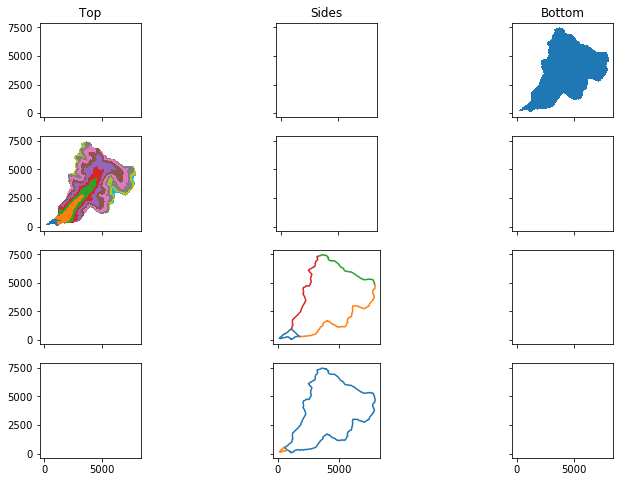

In [3]:
import numpy as np

# Bottom layer
fs_bottom  = tin.facesets.basic(has_top=False,has_bottom=True,has_sides=False)

# Top layer
heights = [3000.6,3124.2,3247.8,3371.4,3495.0,3618.6,3742.2,3865.8,3989.4]
fs_elev = tin.facesets.from_elevations(heights,keep_body=False)

# Sidesets
all_sidesets = np.array([[3352.82,7284.46],[7936.85,4870.53],[1798.4,256.502],[1182.73,1030.19]])
fs_ss   = tin.facesets.sidesets(all_sidesets)

# Outlet
outlet = np.array([[780.41,304.79],[567.05,524.24]])
fs_outlet = tin.facesets.sidesets(outlet,top_layer=True)

# Plot!
tin.plot.plot_facesets(my_dem,[fs_bottom,fs_elev,fs_ss,fs_outlet])

# Conclusions

After we are happy with our facesets, we use the following code to export and visualize them:

In [4]:
import pyvista

tin.dump.to_exodus(my_dem,'facesets_example.exo',facesets=[fs_bottom,fs_elev,fs_ss,fs_outlet])
pyvista.read('facesets_example.exo')['Side Sets'].plot()

[06:04:27 -       write_facesets()] INFO - Preparing sidesets...
[06:04:44 -         __driver_top()] INFO - Preparing surface mesh
[06:04:46 -         __driver_top()] INFO - Creating cut planes
[06:04:46 -         __driver_top()] INFO - Finding elements within cut planes
[06:04:50 -         __driver_top()] INFO - Generating top faceset 1 / 10
[06:04:51 -         __driver_top()] INFO - Generating top faceset 2 / 10
[06:04:52 -         __driver_top()] INFO - Generating top faceset 3 / 10
[06:04:53 -         __driver_top()] INFO - Generating top faceset 4 / 10
[06:04:55 -         __driver_top()] INFO - Generating top faceset 5 / 10
[06:04:56 -         __driver_top()] INFO - Generating top faceset 6 / 10
[06:04:57 -         __driver_top()] INFO - Generating top faceset 7 / 10
[06:04:58 -         __driver_top()] INFO - Generating top faceset 8 / 10
[06:04:59 -         __driver_top()] INFO - Generating top faceset 9 / 10
[06:05:01 -         __driver_top()] INFO - Generating top faceset 10 / 

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')